In [1]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install --upgrade pip setuptools wheel
!pip install opencv-python
!pip install gym[atari]
!pip install keras-rl2

from pyvirtualdisplay import Display
Display().start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libpython2-stdlib python2 python2-minimal
Suggested packages:
  python-tk python-numpy libgle3 python2-doc
The following NEW packages will be installed:
  freeglut3 libpython2-stdlib python-opengl python2 python2-minimal
0 upgraded, 5 newly installed, 0 to remove and 23 not upgraded.
Need to get 621 kB of archives.
After this operation, 6,059 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2-minimal amd64 2.7.17-2ubuntu4 [27.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libpython2-stdlib amd64 2.7.17-2ubuntu4 [7,072 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2 amd64 2.7.17-2ubuntu4 [26.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu f

In [2]:
import numpy as np
from PIL import Image
import gym
from IPython import display
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten,Conv2D,Permute
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy,EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger,ModelIntervalCheckpoint
%matplotlib inline

In [ ]:
# env = gym.make("BreakoutNoFrameskip-v4")

In [3]:
env = gym.make("BreakoutDeterministic-v4")

Error: ignored

In [ ]:
print("Observation Space: ", env.observation_space)
print("Action Space       ", env.action_space)

Observation Space:  Box(0, 255, (210, 160, 3), uint8)
Action Space        Discrete(4)


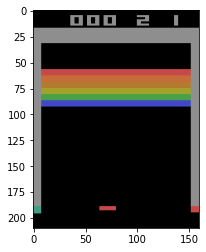

In [ ]:
env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for _ in range(100):
  img.set_data(env.render('rgb_array')) # just update the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  action = env.action_space.sample()
  observation, reward, done, info = env.step(action)
  # if done:
  #   env.reset()
env.close()

In [ ]:
nb_actions = env.action_space.n
nb_actions

4

In [ ]:
IMG_SHAPE = (84,84)
WINDOW_LENGTH = 4

In [ ]:
class ImageProcessor(Processor):
  def process_observation(self,observation):
    img = Image.fromarray(observation)
    img = img.resize(IMG_SHAPE)
    img = img.convert("L")
    img = np.array(img)
    return img.astype('uint8')

  def process_state_batch(self,batch):
    processed_batch = batch.astype('float32')/255.0
    return processed_batch

  def process_reward(self,reward):
    return np.clip(reward,-1.0,1.0)

In [ ]:
input_shape = (WINDOW_LENGTH,IMG_SHAPE[0],IMG_SHAPE[1])
input_shape

(4, 84, 84)

In [ ]:
# Conv2D <--- (Batch,84,84,4)
model = Sequential()

model.add(Permute((2,3,1),input_shape=input_shape))
model.add(Conv2D(32,(8,8),strides=(4,4),kernel_initializer="he_normal"))
model.add(Activation('relu'))

model.add(Conv2D(64,(4,4),strides=(2,2),kernel_initializer="he_normal"))
model.add(Activation('relu'))

model.add(Conv2D(64,(3,3),strides=(1,1),kernel_initializer="he_normal"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 84, 84, 4)         0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 activation (Activation)     (None, 20, 20, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 activation_1 (Activation)   (None, 9, 9, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 activation_2 (Activation)   (None, 7, 7, 64)          0

In [ ]:
memory = SequentialMemory(limit=2000000,window_length=WINDOW_LENGTH)

In [ ]:
processor = ImageProcessor()

In [ ]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),
                              attr='eps',
                              value_max=1.0,
                              value_min=0.1,
                              value_test=0.05,
                              nb_steps=2000000)

In [ ]:
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=100000,
               gamma=.99,target_model_update=20000,
               train_interval=4,delta_clip=1)

In [ ]:
dqn.compile(Adam(learning_rate=0.00025),metrics=['mae'])

In [ ]:
weights_filename = 'DQN_BO.h5f'
checkpoint_filename = 'DQN_CHECKPOINT.h5f'

checkpoint_callback = ModelIntervalCheckpoint(checkpoint_filename,
                                              interval=200000)

In [ ]:
# model.load_weights("weights/dqn_BreakoutDeterministic-v4_weights_900000.h5f")
# policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),
#                               attr='eps',
#                               value_max=0.2,
#                               value_min=0.1,
#                               value_test=0.05,
#                               nb_steps=2000000)

In [ ]:
dqn.fit(env,nb_steps=2000000,callbacks=[checkpoint_callback],
        log_interval=50000,visualize=False,verbose=2)

In [ ]:
dqn.test(env,nb_episodes=1,visualize=True)